## Setup

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
!pip install -q tf-models-official==2.7.0

In [ ]:
!pip install tensorflow_addons

In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
!gdown --no-cookies --id 1f_BAk6dzyXW5MX4E8S0OMWV1k1mqef1X

In [ ]:
!unzip /content/demake_up_data.zip

## Import Module/Library

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

/home/aivn48/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Config Parameters

In [4]:
BATCH_SIZE = 64
IMG_HEGIHT  = 224
IMG_WIDHT   = 224

IMG_CHANNEL = 3
BUFFER_SIZE = BATCH_SIZE*10

IMG_PATH = "./demake_up_data"
np.random.seed(25)  
EPOCHS = 300

##  Load Data

In [5]:
def load(image_file):
    makeup_img_file, non_img_file =  tf.split(image_file,2)
    
    makeup_img = tf.io.read_file(makeup_img_file[0])
    makeup_img = tf.image.decode_jpeg(makeup_img,channels=IMG_CHANNEL)
    
    non_img = tf.io.read_file(non_img_file[0])
    non_img = tf.image.decode_jpeg(non_img,channels=IMG_CHANNEL)
    

    # Convert both images to float32 tensors
    makeup_img  = tf.cast(makeup_img, tf.float32)
    non_img = tf.cast(non_img, tf.float32)
    
    return makeup_img, non_img

(224, 224, 3)
(224, 224, 3)


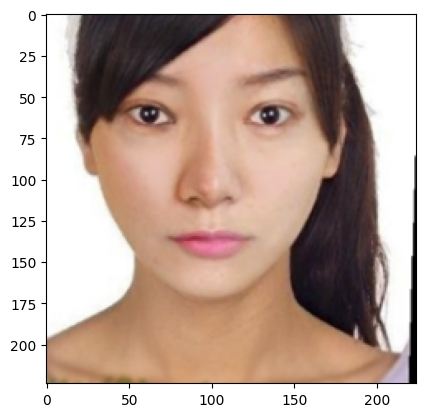

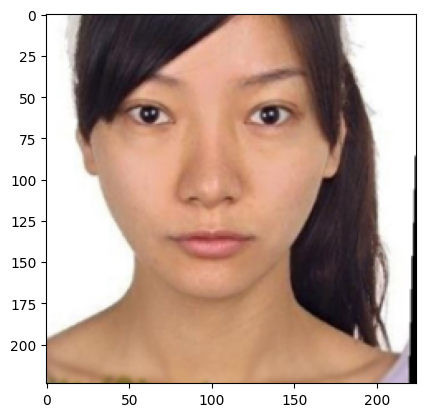

In [6]:

makeup_img, non_img = load([str(IMG_PATH + '/train/makeup/0.png'),
                                    str(IMG_PATH + '/train/non-makeup/0.png')])
print(makeup_img.shape)
print(non_img.shape)



# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(makeup_img/255.0)
plt.figure()
plt.imshow(non_img/255.0)


In [7]:
@tf.function()
def random_flip(makeup_img, non_img):
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        makeup_img = tf.image.flip_left_right(makeup_img)
        non_img = tf.image.flip_left_right(non_img)

    return makeup_img, non_img


def processing_image(makeup_img, non_img):
    makeup_img = (makeup_img / 255.0)
    non_img = (non_img / 255.0)
    
    return makeup_img, non_img


def load_image_train(image_file):
    makeup_img, non_img = load(image_file)
    makeup_img, non_img = random_flip(makeup_img, non_img)
    makeup_img, non_img = processing_image(makeup_img, non_img)

    return makeup_img, non_img


def load_image_val(image_file):
    makeup_img, non_img = load(image_file)
    makeup_img, non_img = processing_image(makeup_img, non_img)

    return makeup_img, non_img 

In [8]:
def prep_data(path):
    makeup_img_list = [os.path.join(path, f) for f in os.listdir(path)]
    data_list = [[i, i.replace('makeup','non-makeup')] for i in makeup_img_list]
    return data_list

train_data_list = prep_data(str(IMG_PATH + '/train/makeup/'))
val_data_list = prep_data(str(IMG_PATH + '/val/makeup/'))
test_data_list = prep_data(str(IMG_PATH + '/test/makeup/'))

np.random.shuffle(train_data_list)
np.random.shuffle(val_data_list)
np.random.shuffle(test_data_list)

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data_list)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


In [10]:
val_dataset = tf.data.Dataset.from_tensor_slices(val_data_list)
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [11]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_data_list)
test_dataset = test_dataset.map(load_image_val)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build Model 

In [12]:
class BuildResNet34():
    def __init__(self):
        pass

    def identity_block(self, inputs, filters):
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(inputs)
        x = tfa.layers.InstanceNormalization()(x)
        x = layers.Activation('gelu')(x)
        
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        x = tfa.layers.InstanceNormalization()(x)
        
        skip_connection = layers.add([inputs, x])     
        x = layers.Activation('gelu')(skip_connection)
        
        return x
    
    
    def projection_block(self, inputs, filters, strides=2):
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=strides, use_bias=False)(inputs)
        x = tfa.layers.InstanceNormalization()(x)
        x = layers.Activation('gelu')(x)
        
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        x = tfa.layers.InstanceNormalization()(x)
        
        shortcut = layers.Conv2D(filters=filters, kernel_size=(1,1), padding='same', 
                                 strides=strides, use_bias=False)(inputs)
        shortcut = tfa.layers.InstanceNormalization()(shortcut)
        skip_connection = layers.add([shortcut, x])        
        x = layers.Activation('gelu')(skip_connection)
        
        return x
    
    def build_model(self, classes, inputs):        
        # conv1
        x = layers.ZeroPadding2D(padding=((3, 3)))(inputs)
        x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)
        x = tfa.layers.InstanceNormalization()(x)
        x = layers.Activation('gelu')(x)
        x = layers.ZeroPadding2D(padding=((1, 1)))(x)
        x = layers.MaxPooling2D(3, strides=2)(x)
        
        # conv2_X
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        x = self.identity_block(x, filters=64)
        
        # conv3_x
        x = self.projection_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        x = self.identity_block(x, filters=128)
        
        # conv4_x
        x = self.projection_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        x = self.identity_block(x, filters=256)
        
        # conv5_x
        x = self.projection_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        x = self.identity_block(x, filters=512)
        
        x = layers.GlobalAveragePooling2D()(x)
        outputs = layers.Dense(classes, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs)

        return model
        

In [13]:
class BuildRes34Unet():
    def __init__(self):
        self.bridge_block_id = 124
        
    
    def conv_block(self, inputs, num_filters):
        x = layers.Conv2D(filters=num_filters, kernel_size=(3,3), padding="same")(inputs)
        x = tfa.layers.InstanceNormalization()(x)
        x = layers.Activation('gelu')(x)
        
        return x
    
    
    def upsample_block(self, inputs, num_filters):
        x = layers.Conv2DTranspose(filters=num_filters, kernel_size=(2,2), strides=2, padding='same')(inputs)
        x = self.conv_block(x, num_filters)
        
        return x
    
    
    def build_model(self, input_shape):
        inputs = layers.Input(shape=input_shape)
        
        # encoder
        build_resnet34 = BuildResNet34()
        backbone = build_resnet34.build_model(classes=1000,  inputs=inputs)
        
        # bridge
        br = backbone.get_layer(index=self.bridge_block_id).output
        
        # decoder
        db3 = self.upsample_block(inputs=br, num_filters=512)
        db2 = self.upsample_block(inputs=db3, num_filters=256)
        db1 = self.upsample_block(inputs=db2, num_filters=128)
        db0 = self.upsample_block(inputs=db1, num_filters=64)
        
        final_feature = self.upsample_block(inputs=db0, num_filters=64)
        outputs = layers.Conv2D(filters=3, kernel_size=(1,1), activation='sigmoid')(final_feature)
        
        model = Model(inputs=inputs, outputs=outputs)
        
        return  model

In [14]:
model = BuildRes34Unet()
res34Unet = model.build_model(input_shape=(IMG_HEGIHT, IMG_WIDHT, IMG_CHANNEL))

In [15]:
res34Unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

                                                                                                  
 activation_7 (Activation)      (None, 28, 28, 128)  0           ['instance_normalization_7[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 28, 28, 128)  8192        ['activation_6[0][0]']           
                                                                                                  
 conv2d_8 (Conv2D)              (None, 28, 28, 128)  147456      ['activation_7[0][0]']           
                                                                                                  
 instance_normalization_9 (Inst  (None, 28, 28, 128)  256        ['conv2d_9[0][0]']               
 anceNormalization)                                                                               
          

                                                                 ']                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 14, 14, 256)  32768       ['activation_14[0][0]']          
                                                                                                  
 conv2d_17 (Conv2D)             (None, 14, 14, 256)  589824      ['activation_15[0][0]']          
                                                                                                  
 instance_normalization_18 (Ins  (None, 14, 14, 256)  512        ['conv2d_18[0][0]']              
 tanceNormalization)                                                                              
                                                                                                  
 instance_normalization_17 (Ins  (None, 14, 14, 256)  512        ['conv2d_17[0][0]']              
 tanceNorm

                                                                                                  
 conv2d_26 (Conv2D)             (None, 14, 14, 256)  589824      ['activation_23[0][0]']          
                                                                                                  
 instance_normalization_26 (Ins  (None, 14, 14, 256)  512        ['conv2d_26[0][0]']              
 tanceNormalization)                                                                              
                                                                                                  
 add_11 (Add)                   (None, 14, 14, 256)  0           ['activation_22[0][0]',          
                                                                  'instance_normalization_26[0][0]
                                                                 ']                               
                                                                                                  
 activatio

 conv2d_35 (Conv2D)             (None, 7, 7, 512)    2359296     ['activation_31[0][0]']          
                                                                                                  
 instance_normalization_35 (Ins  (None, 7, 7, 512)   1024        ['conv2d_35[0][0]']              
 tanceNormalization)                                                                              
                                                                                                  
 add_15 (Add)                   (None, 7, 7, 512)    0           ['activation_30[0][0]',          
                                                                  'instance_normalization_35[0][0]
                                                                 ']                               
                                                                                                  
 activation_32 (Activation)     (None, 7, 7, 512)    0           ['add_15[0][0]']                 
          

## Config and Compile Model

### Show Generated Images and Evaluation Function

In [17]:
def evaluate(model, epoch, dataset):  
    psnr_non_mean = 0.0
    psnr_sr_mean = 0.0
    count = 0
    for makeup_img, non_img in dataset:
        
        pred_non = model([makeup_img], training=False)
        
        psnr_non = tf.image.psnr(pred_non, non_img, max_val=1.0)

        __psnr_non_mean = tf.math.reduce_mean(psnr_non)
        # psnr_mean = psnr_mean_l
        
        psnr_non_mean += __psnr_non_mean
        count =count + 1
    
    psnr_non_mean = psnr_non_mean/count
    print('-------- psnr_non: ', psnr_non_mean.numpy(), '----- epoch: ', epoch, '  count: ', count)
    
    return psnr_non_mean
    

def generate_images(model, makeup_img, non_img):
    pred_non = model([makeup_img], training=False)
    plt.figure(figsize=(15,20))
    
    display_list = [makeup_img[0], non_img[0], pred_non[0]]
    
    
    title = ['Input', 'Non-makeup', 'Predicted']    

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

### Optimizer

In [18]:

from official.nlp import optimization  # to create AdamW optimizer
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-2
generator_optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

## Training

In [19]:

@tf.function
def train_step(model, makeup_img, non_img):
    with tf.GradientTape() as tape:
        # output
        pred_non = model([makeup_img], training=True)     
        loss = tf.reduce_mean(tf.square(pred_non-non_img))*100
        
    generator_gradients = tape.gradient(loss, model.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, model.trainable_variables))
    
    return loss

    
    
def fit(model, train_ds, epochs, val_ds):
    best_pnsr = 0.0
    step_counter = 0
    for epoch in range(epochs):
        # Train
        total_loss = 0.0
        for makeup_img, non_img in train_ds:
            loss = train_step(model, makeup_img, non_img)
            total_loss = total_loss + loss
            step_counter += 1
        total_loss = total_loss/step_counter
        print('epoch: {}   loss: {}'.format(epoch, total_loss))
        
        pnsr = evaluate(model, epoch, val_ds)     
        if best_pnsr < pnsr:
            best_pnsr = pnsr
            
            for makeup_img, non_img in val_ds.take(1):
                generate_images(model, makeup_img, non_img)


2023-02-02 12:34:14.270565: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


epoch: 0   loss: 5.898923873901367


2023-02-02 12:35:32.669520: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


-------- psnr_non:  16.238281 ----- epoch:  0   count:  8


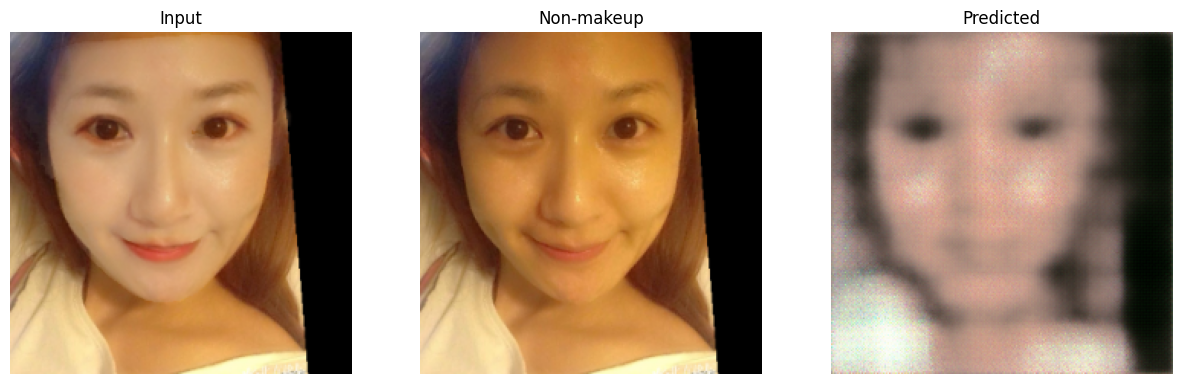

epoch: 1   loss: 0.9809290170669556
-------- psnr_non:  17.961758 ----- epoch:  1   count:  8


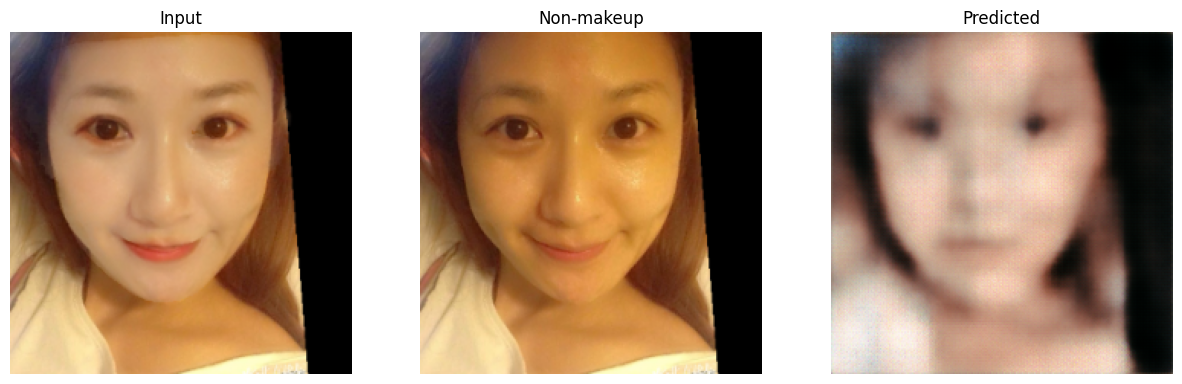

epoch: 2   loss: 0.532997727394104
-------- psnr_non:  18.25487 ----- epoch:  2   count:  8


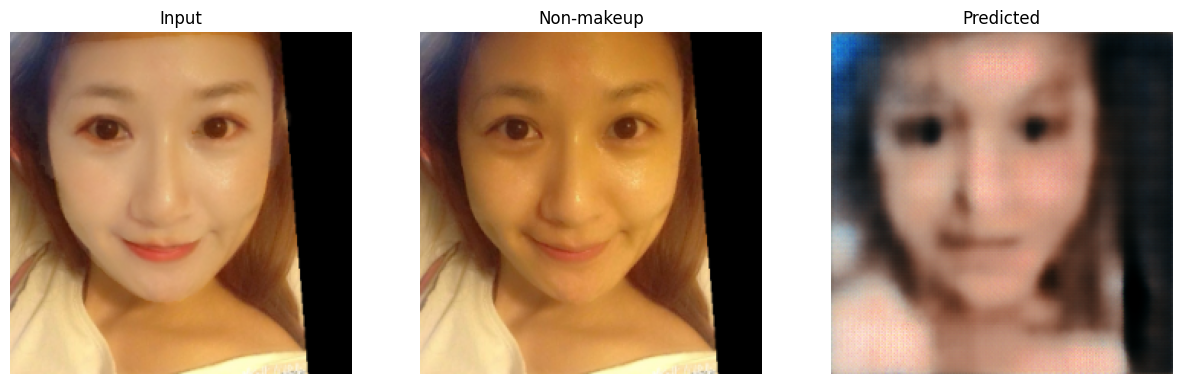

epoch: 3   loss: 0.3672461211681366
-------- psnr_non:  18.265877 ----- epoch:  3   count:  8


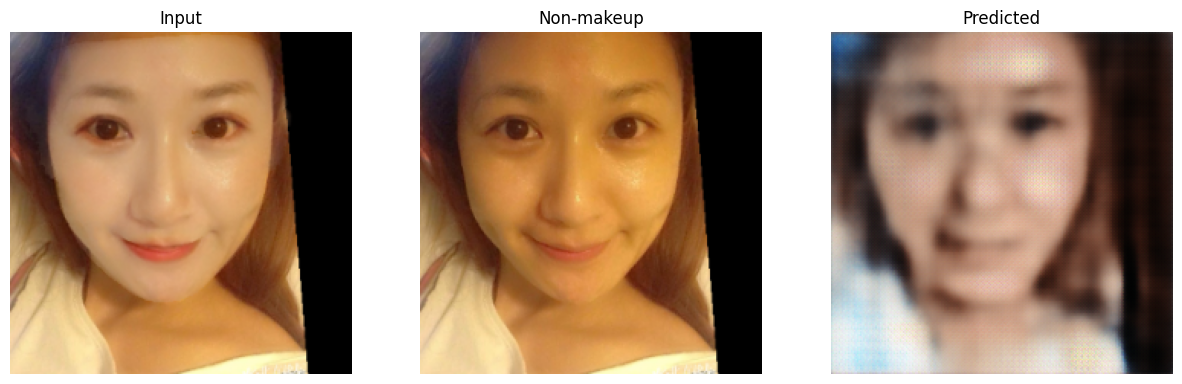

epoch: 4   loss: 0.24780704081058502
-------- psnr_non:  18.55606 ----- epoch:  4   count:  8


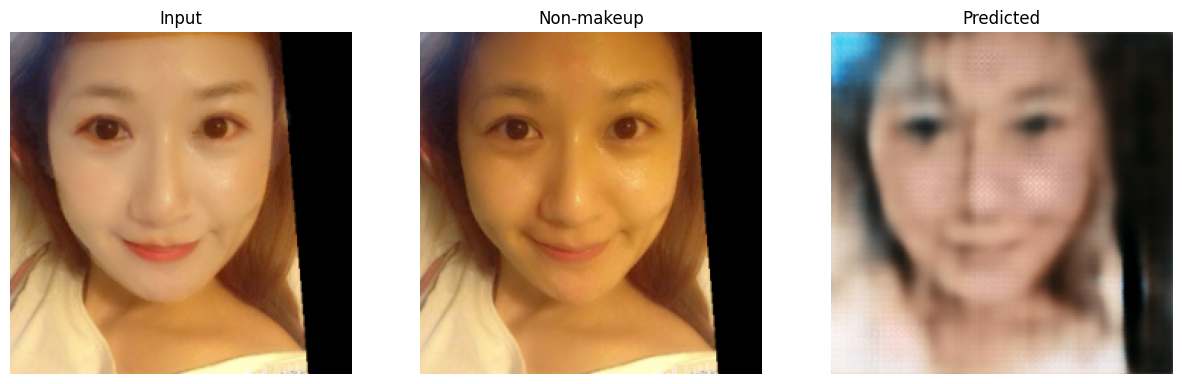

epoch: 5   loss: 0.20422597229480743
-------- psnr_non:  19.61449 ----- epoch:  5   count:  8


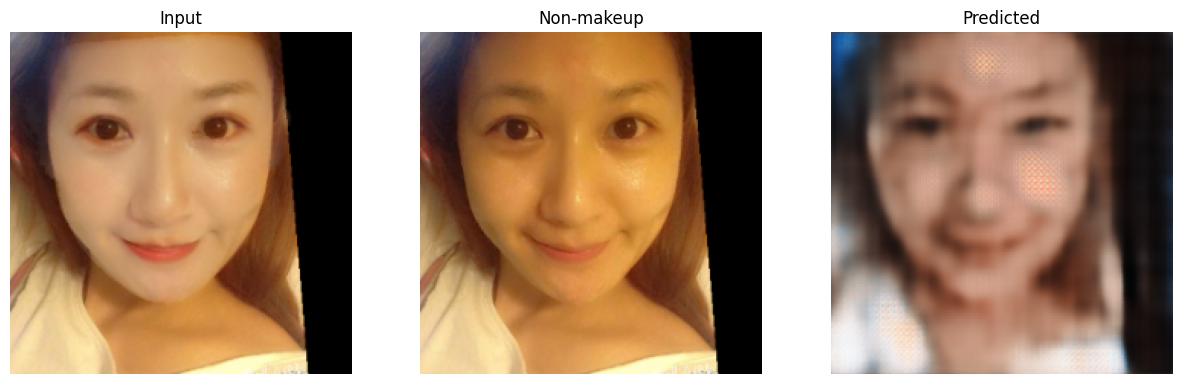

epoch: 6   loss: 0.14614088833332062
-------- psnr_non:  19.568092 ----- epoch:  6   count:  8
epoch: 7   loss: 0.11677337437868118
-------- psnr_non:  19.537195 ----- epoch:  7   count:  8
epoch: 8   loss: 0.08956070989370346
-------- psnr_non:  20.201738 ----- epoch:  8   count:  8


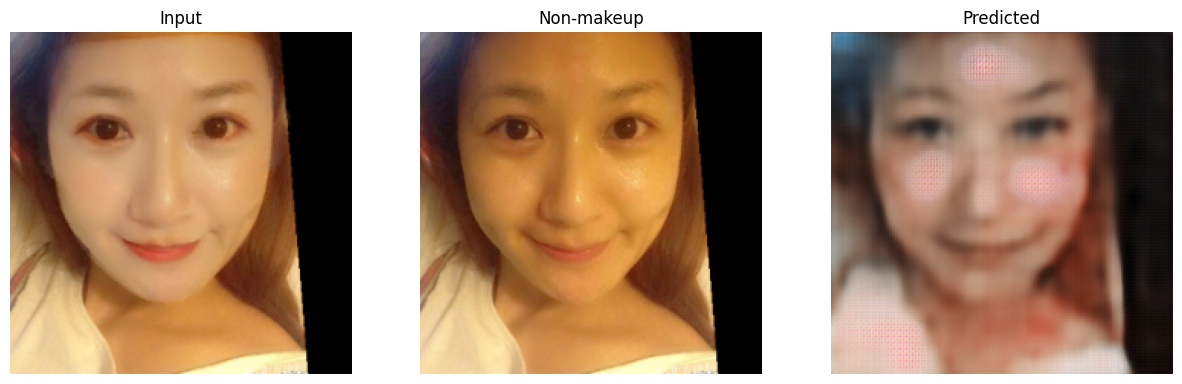

epoch: 9   loss: 0.07386434078216553
-------- psnr_non:  20.435856 ----- epoch:  9   count:  8


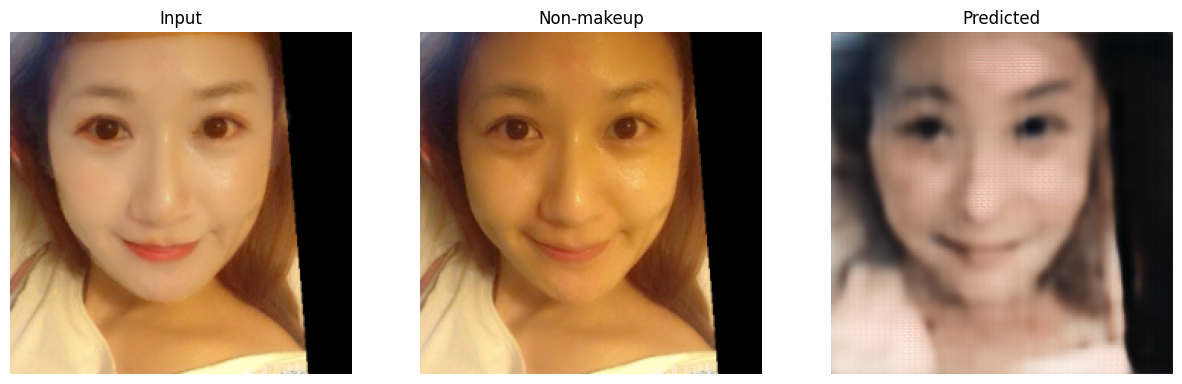

epoch: 10   loss: 0.06147805228829384
-------- psnr_non:  20.765041 ----- epoch:  10   count:  8


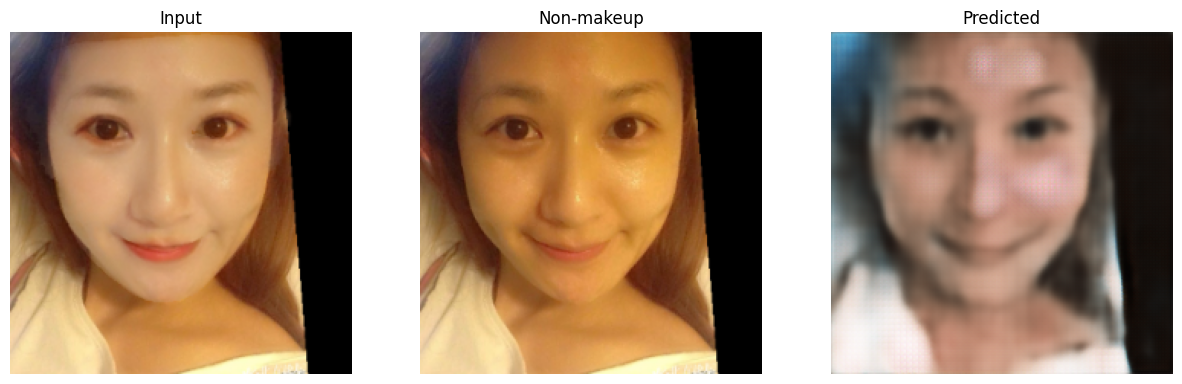

epoch: 11   loss: 0.04920497164130211
-------- psnr_non:  20.974176 ----- epoch:  11   count:  8


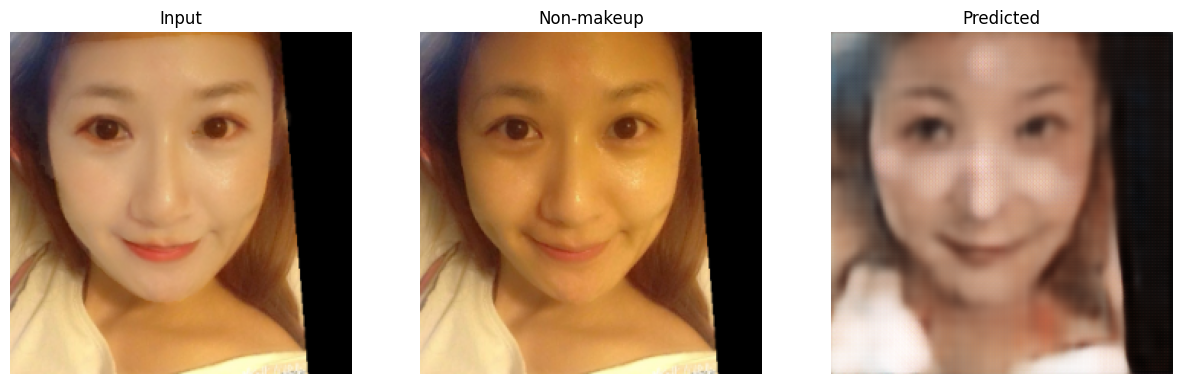

epoch: 12   loss: 0.04128386080265045
-------- psnr_non:  21.44374 ----- epoch:  12   count:  8


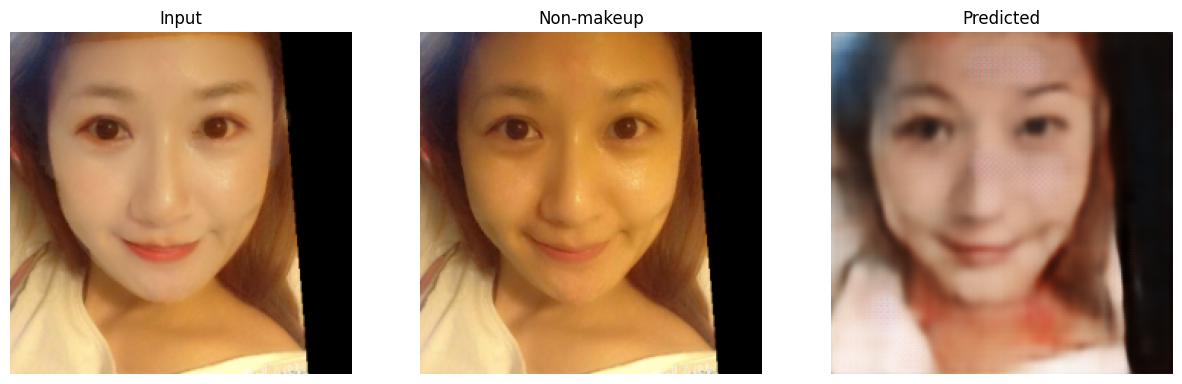

epoch: 13   loss: 0.03506952524185181
-------- psnr_non:  21.609224 ----- epoch:  13   count:  8


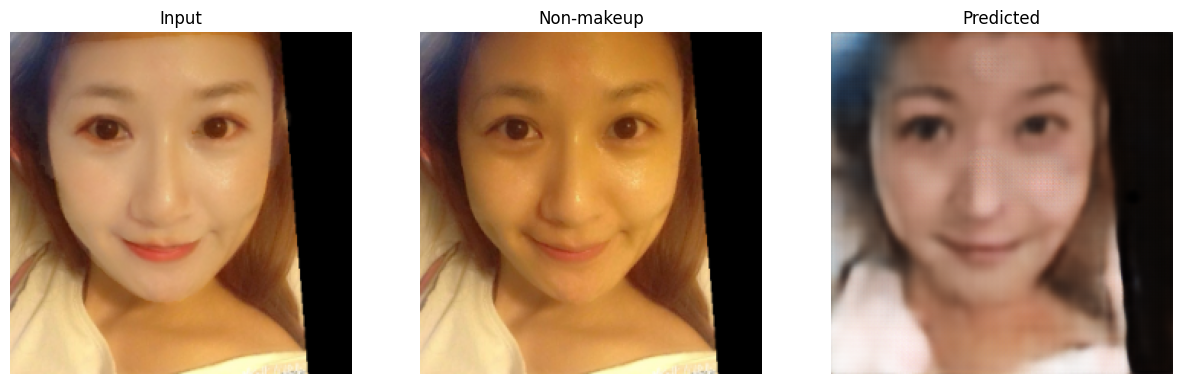

epoch: 14   loss: 0.030526503920555115
-------- psnr_non:  21.617289 ----- epoch:  14   count:  8


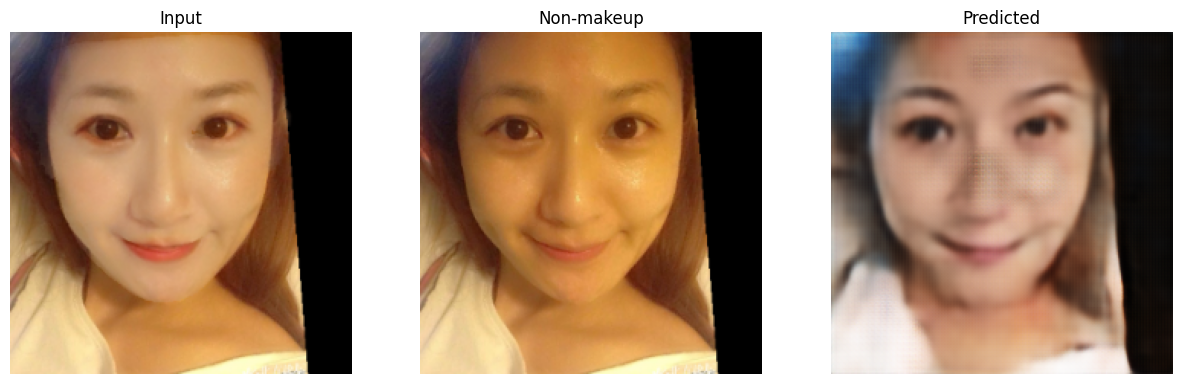

epoch: 15   loss: 0.02378074638545513
-------- psnr_non:  21.899586 ----- epoch:  15   count:  8


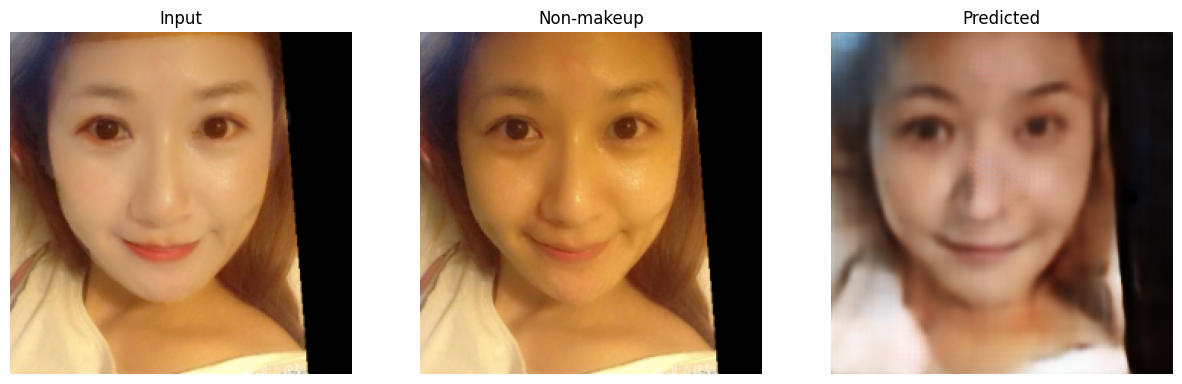

epoch: 16   loss: 0.022830791771411896
-------- psnr_non:  21.639639 ----- epoch:  16   count:  8
epoch: 17   loss: 0.020707232877612114
-------- psnr_non:  21.714931 ----- epoch:  17   count:  8
epoch: 18   loss: 0.018408354371786118
-------- psnr_non:  21.882042 ----- epoch:  18   count:  8
epoch: 19   loss: 0.017939772456884384
-------- psnr_non:  22.108875 ----- epoch:  19   count:  8


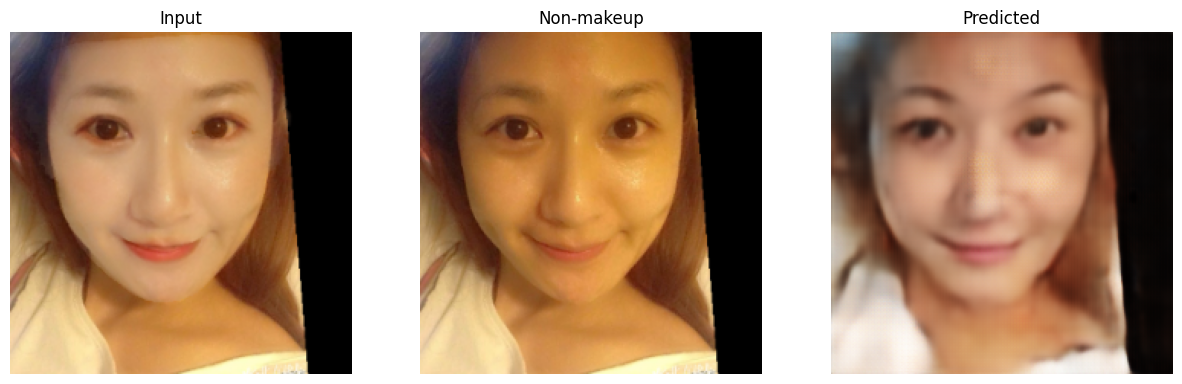

epoch: 20   loss: 0.014536545611917973
-------- psnr_non:  22.429565 ----- epoch:  20   count:  8


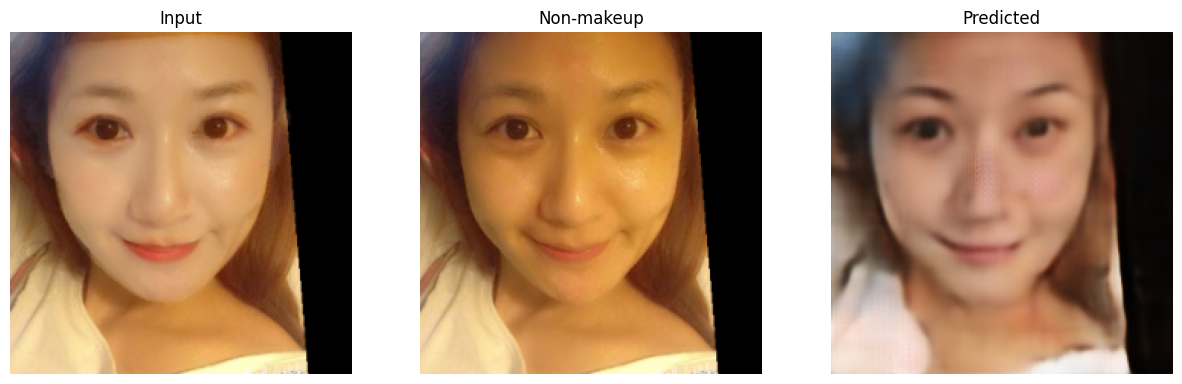

epoch: 21   loss: 0.013444831594824791
-------- psnr_non:  22.206997 ----- epoch:  21   count:  8
epoch: 22   loss: 0.012264084070920944
-------- psnr_non:  22.400656 ----- epoch:  22   count:  8
epoch: 23   loss: 0.011456099338829517
-------- psnr_non:  21.777786 ----- epoch:  23   count:  8
epoch: 24   loss: 0.01133489329367876
-------- psnr_non:  22.291706 ----- epoch:  24   count:  8
epoch: 25   loss: 0.010007810778915882
-------- psnr_non:  21.997248 ----- epoch:  25   count:  8
epoch: 26   loss: 0.009871470741927624
-------- psnr_non:  22.174074 ----- epoch:  26   count:  8
epoch: 27   loss: 0.00877340417355299
-------- psnr_non:  22.326271 ----- epoch:  27   count:  8
epoch: 28   loss: 0.0076104518957436085
-------- psnr_non:  22.200531 ----- epoch:  28   count:  8
epoch: 29   loss: 0.00862342119216919
-------- psnr_non:  22.049595 ----- epoch:  29   count:  8
epoch: 30   loss: 0.007027343846857548
-------- psnr_non:  22.502949 ----- epoch:  30   count:  8


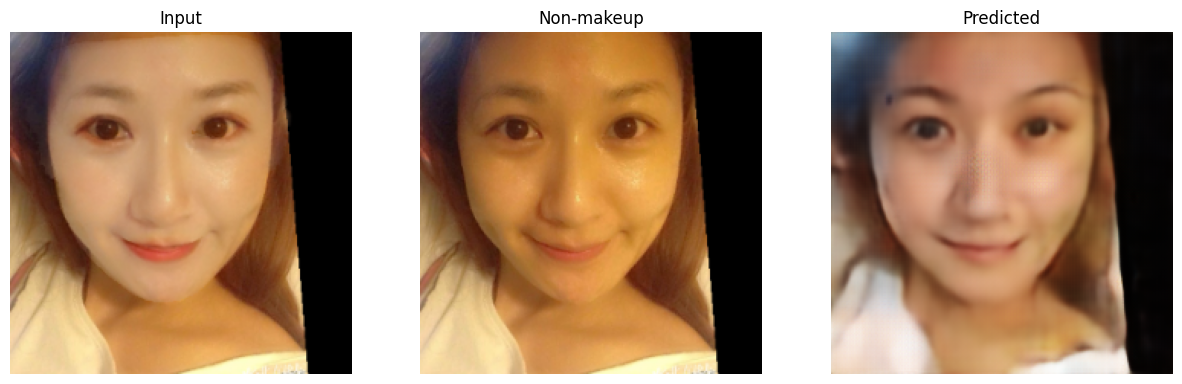

epoch: 31   loss: 0.006141194608062506
-------- psnr_non:  22.500568 ----- epoch:  31   count:  8
epoch: 32   loss: 0.005551736801862717
-------- psnr_non:  22.39993 ----- epoch:  32   count:  8
epoch: 33   loss: 0.005467205308377743
-------- psnr_non:  22.574995 ----- epoch:  33   count:  8


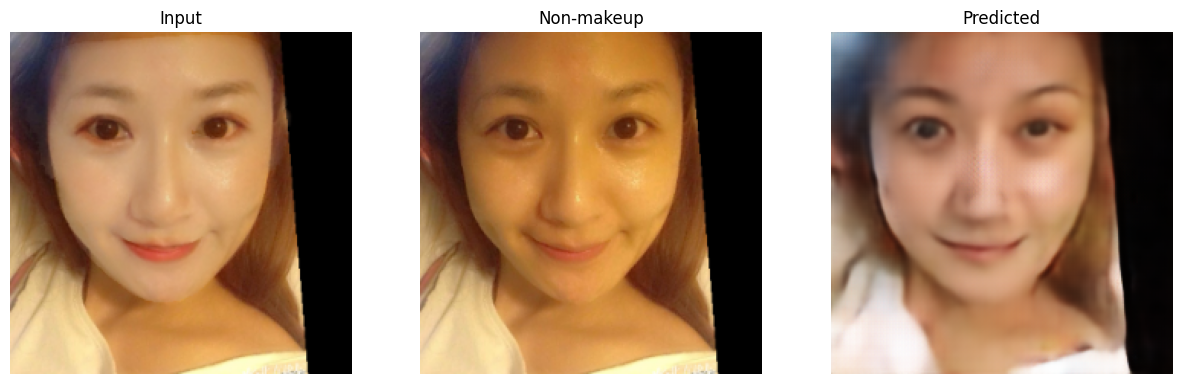

epoch: 34   loss: 0.005354793276637793
-------- psnr_non:  22.260715 ----- epoch:  34   count:  8
epoch: 35   loss: 0.005129873286932707
-------- psnr_non:  22.196444 ----- epoch:  35   count:  8
epoch: 36   loss: 0.00501774437725544
-------- psnr_non:  22.491283 ----- epoch:  36   count:  8
epoch: 37   loss: 0.004468098748475313
-------- psnr_non:  21.84499 ----- epoch:  37   count:  8
epoch: 38   loss: 0.004600341431796551
-------- psnr_non:  22.568079 ----- epoch:  38   count:  8
epoch: 39   loss: 0.004078426863998175
-------- psnr_non:  22.519156 ----- epoch:  39   count:  8
epoch: 40   loss: 0.0037850106600672007
-------- psnr_non:  22.12556 ----- epoch:  40   count:  8
epoch: 41   loss: 0.004094287287443876
-------- psnr_non:  22.214231 ----- epoch:  41   count:  8
epoch: 42   loss: 0.003686540527269244
-------- psnr_non:  22.423363 ----- epoch:  42   count:  8
epoch: 43   loss: 0.0035741867031902075
-------- psnr_non:  22.328047 ----- epoch:  43   count:  8
epoch: 44   loss: 0.0

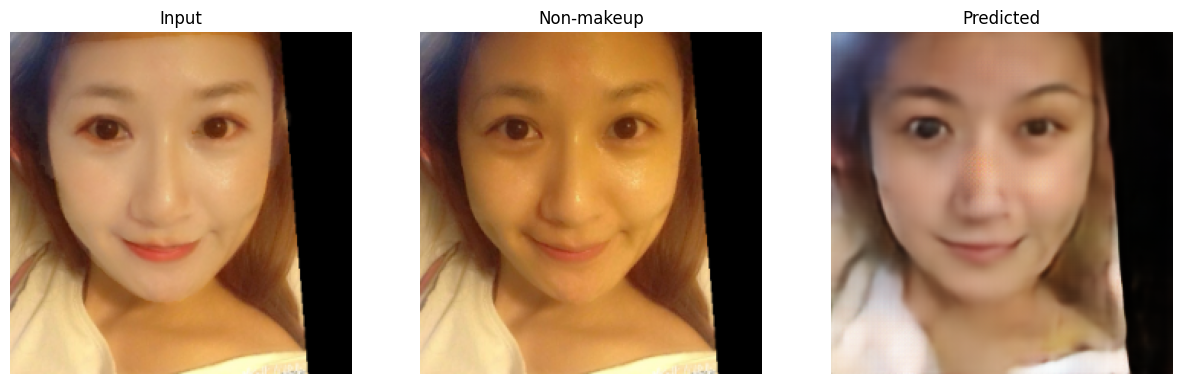

epoch: 45   loss: 0.003255205461755395
-------- psnr_non:  22.510042 ----- epoch:  45   count:  8
epoch: 46   loss: 0.003107095370069146
-------- psnr_non:  22.353075 ----- epoch:  46   count:  8
epoch: 47   loss: 0.0031799429561942816
-------- psnr_non:  22.518045 ----- epoch:  47   count:  8
epoch: 48   loss: 0.002770235063508153
-------- psnr_non:  22.53395 ----- epoch:  48   count:  8
epoch: 49   loss: 0.0026984948199242353
-------- psnr_non:  22.358624 ----- epoch:  49   count:  8
epoch: 50   loss: 0.003211946925148368
-------- psnr_non:  22.443232 ----- epoch:  50   count:  8
epoch: 51   loss: 0.002831837860867381
-------- psnr_non:  22.593391 ----- epoch:  51   count:  8
epoch: 52   loss: 0.0024417059030383825
-------- psnr_non:  22.611927 ----- epoch:  52   count:  8


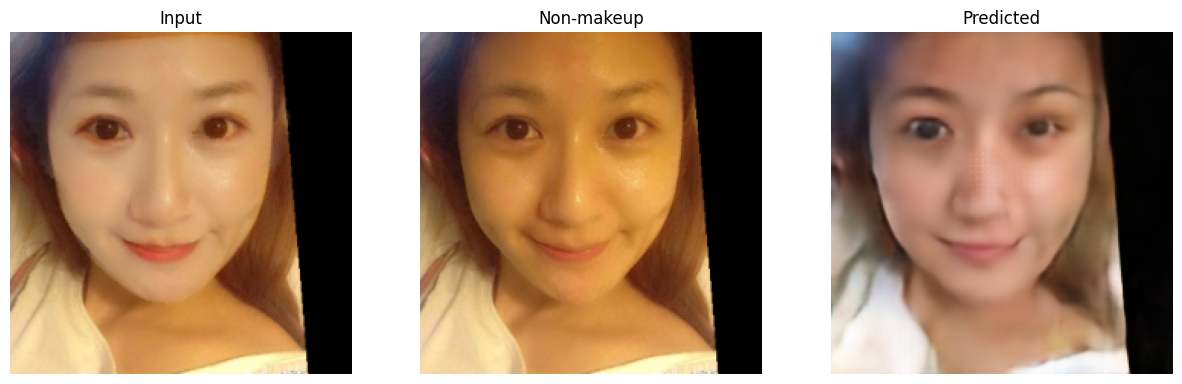

epoch: 53   loss: 0.0023193464148789644
-------- psnr_non:  22.44569 ----- epoch:  53   count:  8
epoch: 54   loss: 0.0027049623895436525
-------- psnr_non:  21.976007 ----- epoch:  54   count:  8
epoch: 55   loss: 0.0026222714222967625
-------- psnr_non:  22.354733 ----- epoch:  55   count:  8
epoch: 56   loss: 0.002518509980291128
-------- psnr_non:  22.507257 ----- epoch:  56   count:  8
epoch: 57   loss: 0.0021613778080791235
-------- psnr_non:  22.42489 ----- epoch:  57   count:  8
epoch: 58   loss: 0.002135304966941476
-------- psnr_non:  22.449282 ----- epoch:  58   count:  8
epoch: 59   loss: 0.001927374629303813
-------- psnr_non:  22.47943 ----- epoch:  59   count:  8
epoch: 60   loss: 0.001958225853741169
-------- psnr_non:  22.482262 ----- epoch:  60   count:  8
epoch: 61   loss: 0.002062347950413823
-------- psnr_non:  22.371288 ----- epoch:  61   count:  8
epoch: 62   loss: 0.001887046848423779
-------- psnr_non:  22.548075 ----- epoch:  62   count:  8
epoch: 63   loss: 0

-------- psnr_non:  22.08447 ----- epoch:  135   count:  8
epoch: 136   loss: 0.0005209891241975129
-------- psnr_non:  22.139956 ----- epoch:  136   count:  8
epoch: 137   loss: 0.0004634229408111423
-------- psnr_non:  21.98612 ----- epoch:  137   count:  8
epoch: 138   loss: 0.0004335783305577934
-------- psnr_non:  22.087572 ----- epoch:  138   count:  8
epoch: 139   loss: 0.00042140859295614064
-------- psnr_non:  22.149837 ----- epoch:  139   count:  8
epoch: 140   loss: 0.0004884272930212319
-------- psnr_non:  22.049198 ----- epoch:  140   count:  8
epoch: 141   loss: 0.000431754655437544
-------- psnr_non:  22.152203 ----- epoch:  141   count:  8
epoch: 142   loss: 0.0004016424354631454
-------- psnr_non:  22.152817 ----- epoch:  142   count:  8
epoch: 143   loss: 0.00041916139889508486
-------- psnr_non:  22.124222 ----- epoch:  143   count:  8
epoch: 144   loss: 0.00043725737486965954
-------- psnr_non:  22.065735 ----- epoch:  144   count:  8
epoch: 145   loss: 0.0003900896

-------- psnr_non:  21.865246 ----- epoch:  216   count:  8
epoch: 217   loss: 0.00017163073061965406
-------- psnr_non:  21.808708 ----- epoch:  217   count:  8
epoch: 218   loss: 0.00016521076031494886
-------- psnr_non:  21.849209 ----- epoch:  218   count:  8
epoch: 219   loss: 0.00016124873945955187
-------- psnr_non:  21.809565 ----- epoch:  219   count:  8
epoch: 220   loss: 0.00015938928117975593
-------- psnr_non:  21.821074 ----- epoch:  220   count:  8
epoch: 221   loss: 0.00016029599646572024
-------- psnr_non:  21.791279 ----- epoch:  221   count:  8
epoch: 222   loss: 0.00015736231580376625
-------- psnr_non:  21.795916 ----- epoch:  222   count:  8
epoch: 223   loss: 0.0001531953748781234
-------- psnr_non:  21.824726 ----- epoch:  223   count:  8
epoch: 224   loss: 0.0001510606671217829
-------- psnr_non:  21.796368 ----- epoch:  224   count:  8
epoch: 225   loss: 0.0001523162645753473
-------- psnr_non:  21.773954 ----- epoch:  225   count:  8
epoch: 226   loss: 0.0001

-------- psnr_non:  21.398548 ----- epoch:  297   count:  8
epoch: 298   loss: 8.380119106732309e-05
-------- psnr_non:  21.397936 ----- epoch:  298   count:  8
epoch: 299   loss: 8.35317769087851e-05
-------- psnr_non:  21.397175 ----- epoch:  299   count:  8


In [20]:
fit(res34Unet, train_dataset, EPOCHS, val_dataset)